In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb

***************************

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
df_train = reduce_mem_usage(pd.read_csv("train.csv"))
df_test = reduce_mem_usage(pd.read_csv("test.csv"))

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 159.10 MB
Decreased by 48.4%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 158.91 MB
Decreased by 48.2%


**Задание 1**:
 
Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [5]:
display(df_train.head(2), df_test.head(2))

ID_code  target    var_0   var_1    var_2  var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.093  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.389  12.3622  7.0433  5.6208   

     var_7  ...  var_190  var_191  var_192  var_193    var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.522699  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.430500   2.0339   

   var_196  var_197    var_198  var_199  
0   7.8784   8.5635  12.780300  -1.0914  
1   8.1267   8.7889  18.356001   1.9518  

[2 rows x 202 columns]

ID_code    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656  7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304  1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   

       var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  \
0  18.267500  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   
1  18.631599 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   

   var_195  var_196  var_197    var_198  var_199  
0   2.4669   4.3654  10.7200  15.472200  -8.7197  
1   0.4773  -1.4852   9.8714  19.129299 -20.9760  

[2 rows x 201 columns]

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: category(1), float32(200), int8(1)
memory usage: 159.1 MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: category(1), float32(200)
memory usage: 158.9 MB


In [8]:
display(df_train.describe(percentiles=[.5]),
        df_test.describe(percentiles=[.5])
        )

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679973      -1.627628      10.715126   
std         0.300653       3.039990       4.049967       2.640832   
min         0.000000       0.408400     -15.043400       2.117100   
50%         0.000000      10.524750      -1.608050      10.580000   
max         1.000000      20.315001      10.376800      19.353001   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796523      11.078255      -5.065340       5.408961   
std         2.043276       1.623114       7.863115       0.866585   
min        -0.040200       5.074800     -32.562599       2.347300   
50%         6.825000      11.108250      -4.833150       5.385100   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545988       0.284159  ...       3.234436       7.438449   
std         3.418009       3.332576  ...       4.559854       3.023208   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
50%        16.456800       0.393700  ...       3.203600       7.347750   
max        27.691799      10.151300  ...      18.440901      16.716499   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927833       3.331773      17.993811      -0.142087   
std         1.478388       3.991934       3.135113       1.429341   
min        -3.814500     -11.783400       8.694400      -5.261000   
50%         1.901300       3.396350      17.957950      -0.172700   
max         8.402400      18.281799      27.928801       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303355       8.908224      15.870864      -3.326542  
std         5.454274       0.921603       3.010892      10.437832  
min       -14.209600       5.960600       6.299300     -38.852798  
50%         2.408900       8.888200      15.934050      -2.819550  
max        18.321501      12.000400      26.079100      28.500700  

[6 rows x 201 columns]

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658732      -1.624240      10.707497       6.788238   
std         3.036675       4.040431       2.633820       2.052685   
min         0.188700     -15.043400       2.355200      -0.022400   
50%        10.513800      -1.590500      10.560700       6.822350   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076387      -5.050552       5.415207      16.529312   
std         1.616426       7.869115       0.864669       3.424418   
min         5.484400     -27.767000       2.216400       5.713700   
50%        11.099750      -4.834100       5.391600      16.422700   
max        16.037100      17.253700       8.302500      28.292801   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277133       7.569351  ...       3.189724       7.458230   
std         3.333328       1.231836  ...       4.551188       3.025138   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
50%         0.372000       7.632000  ...       3.162400       7.379000   
max         9.665500      11.003600  ...      20.358999      16.716499   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925958       3.322033      17.996922      -0.133656   
std         1.479932       3.995498       3.140603       1.429652   
min        -3.340900     -11.413100       9.382800      -4.911900   
50%         1.892600       3.428500      17.977600      -0.162000   
max         8.005000      17.632601      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290916       8.912555      15.869393      -3.246347  
std         5.446252       0.920886       3.008664      10.398454  
min       -13.944200       6.169600       6.584000     -39.457802  
50%         2.403600       8.892800      15.943400      -2.725950  
max        15.920700      12.275800      26.538401      27.907400  

[6 rows x 200 columns]

In [9]:
numerical_features = df_train.select_dtypes(include=[np.number])

discrete_features = [
    feature for feature in numerical_features
    if len(df_train[feature].unique()) < 25
]
discrete_features.remove('target')

continuous_features = [
    feature for feature in numerical_features
    if feature not in discrete_features
]
continuous_features.remove('target')

print(f"Количество числовых признаков (+target): {numerical_features.shape[1]}")
print(f"Количество признаков с дискретными величинами: {len(discrete_features)}")
print(f"Количество признаков с непрерывными величинами: {len(continuous_features)}")

Количество числовых признаков (+target): 201
Количество признаков с дискретными величинами: 0
Количество признаков с непрерывными величинами: 200


In [10]:
msno.matrix(df_train);

In [11]:
print(f'Количество пропусков в train: {df_train.isnull().sum().sum()}',
      f'Количество пропусков в test: {df_test.isnull().sum().sum()}', sep='\n')

Количество пропусков в train: 0
Количество пропусков в test: 0


**********************

**Задание 2:** 

Сделать базовый анализ целевой переменной, сделать выводы;

In [12]:
df_train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [13]:
disbalanse = df_train['target'].value_counts(normalize=True)
print(f'Дисбаланс классов: количество наблюдений негативного класса - {disbalanse[0]}, позитивного - {disbalanse[1]}')

Дисбаланс классов: количество наблюдений негативного класса - 0.89951, позитивного - 0.10049


*******************************

**Задание 3:**

 Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки

In [14]:
fig, axes = plt.subplots(50, 4, figsize=(20, 200))

for num, feature in enumerate(continuous_features):
    try:
        train_data, test_data = df_train[feature].copy(), df_test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = df_train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num % 4].set_title(feature, fontsize=14)
    axes[num//4, num % 4].set(xlabel=None)

Распределения +- схожи

********************

**Задание 4:**

 Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [15]:
stat_target_1 = df_train.loc[df_train['target']
                             == 1, :].describe(percentiles=[.5])
stat_target_0 = df_train.loc[df_train['target']
                             == 0, :].describe(percentiles=[.5])

df_stat = pd.DataFrame(data={'mean_0': stat_target_0.loc['mean'],
                             'std_0': stat_target_0.loc['std'],
                             'mean_1': stat_target_1.loc['mean'],
                             'std_1': stat_target_1.loc['std'],
                             })
df_stat.head(5)

mean_0     std_0     mean_1     std_1
target   0.000000  0.000000   1.000000  0.000000
var_0   10.626724  3.008511  11.156417  3.270290
var_1   -1.695775  4.024729  -1.017615  4.220634
var_2   10.665834  2.612930  11.156603  2.841071
var_3    6.788943  2.040052   6.864108  2.070897

Собственно есть признаки где различия основыных статистик стремиться к 0, есть с более значимыми различиями

In [16]:
df_stat_train_test = pd.DataFrame(data={'mean_train': df_train.describe().loc['mean'],
                                        'std_train': df_train.describe().loc['std'],
                                        'mean_test': df_test.describe().loc['mean'],
                                        'std_test': df_test.describe().loc['std'],
                                        })

df_stat_train_test.head(5)

mean_train  std_train  mean_test  std_test
target     0.100490   0.300653        NaN       NaN
var_0     10.679973   3.039990  10.658732  3.036675
var_1     -1.627628   4.049967  -1.624240  4.040431
var_10     0.394344   5.500725   0.371336  5.508538
var_100   -6.600573   9.181515  -6.674091  9.181478

Нет существенных различий между train и test

******************************

**Задание 5:** 

Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [17]:
corr_target = numerical_features.corr()
corr_target = corr_target["target"].sort_values(ascending=False)[1:]
corr_target.head(10)

var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
Name: target, dtype: float64

Heatmap можно не строить (неинформативно). Линейной зависимости нет (<0.2)

**************************

**Задание 6:**

Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [18]:
%%time

target = df_train['target']
feature_names = numerical_features.drop("target", axis=1).columns
parameters = {"max_depth": 6, "n_estimators": 25,
              "random_state": 27, "n_jobs": -1}

model = RandomForestRegressor(**parameters)
model.fit(df_train[feature_names], target)

Wall time: 59 s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=-1, random_state=27)

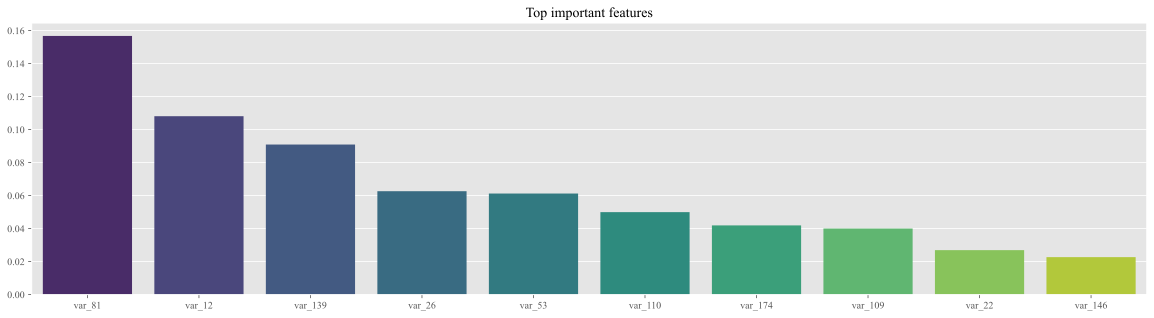

In [19]:
n_top = 10
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Top important features", size=14)
plt.show()

************************************************

**Задание 7 (опция):**

Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [20]:
from scipy.stats import mannwhitneyu

In [21]:
def train_test_num_analysis(train_df, test_df, column_list):

    fig = plt.figure(facecolor='whitesmoke', figsize=(9, len(column_list)*3))

    total_axes = len(column_list)
    subplt = 1
    for col in column_list:
        ax = fig.add_subplot(total_axes, 2, subplt)
        u, prob = mannwhitneyu(train_df[col], test_df[col])
        prob = round(prob, 3)
#             sns.set_style("whitegrid", {"axes.facecolor": ".9"})
        sns.kdeplot(train_df[col], shade=True, label='train', color='darkblue')
        sns.kdeplot(test_df[col], shade=True, label='test', color='darkred')
        plt.ylabel('Density', fontsize=12)
        plt.xlabel(col, fontsize=14,)
        plt.xticks(rotation=90)
        plt.title('Mann-Whitney p-value = '+str(prob),
                  fontsize=14, weight='bold')
        subplt += 1
        plt.legend(loc='best')
        fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.show()

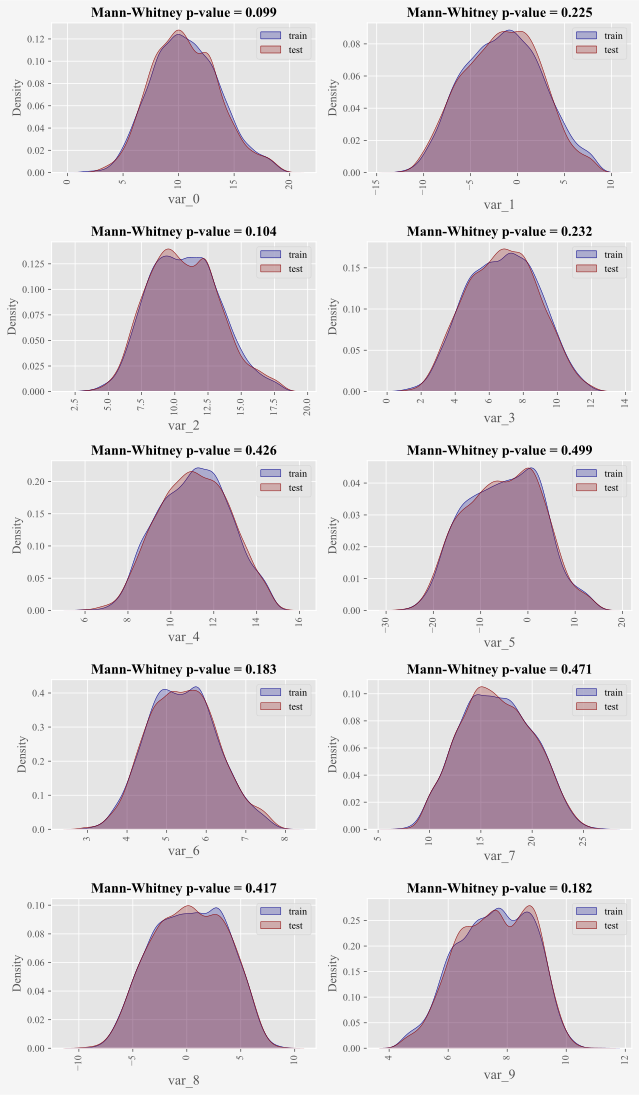

In [22]:
# U-критерий Манна-Уитни используется для оценки различий между двумя независимыми выборками
# по уровню какого-либо количественного признака.
# 10 фичей отобрано для ознакомления
train_test_num_analysis(df_train.sample(5000), df_test.sample(5000), feature_names[:10])

для ряда праметров различия в значении средних статистически значимы.(p<0.05). Не до конца понятно как это интерпретировать для двух схожих наборов данных.

In [23]:
features_to_score = numerical_features.drop(
    ["target"], axis=1).columns.tolist()

X_adv = pd.concat([
    df_train[features_to_score], df_test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(df_train.shape[0]), np.zeros(df_test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [24]:
%%time
parameters = {"max_depth": 4,
              "n_estimators": 50,
              "random_state": 27,
              "n_jobs": -1,
              "eval_metric": "logloss"
             }

model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 1min 23s


 Предсказания модели близки к random-классификатору --> различия незначительны